In [75]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


So, I managed to apply the Salpeter -> Chabrier conversion in the wrong direction and now the number counts won't add up unless we re-fit M\*-MUV.  This was done by using an anchor at z~4 for the slope, intercept and scatter that would convert between the Bouwens luminosity function, and the chosen mass function.

We have some choices to make about the exact form of the fitting but for now I want to write the program that determines this anchor.  

In [76]:
def schechterMUV(Marr,modelParams):
    phi = (np.log(10)/2.5)*modelParams['phiStar']*\
          np.power(10,(-0.4)*(Marr-modelParams['logMstar'])*(1+modelParams['alpha']))*\
          np.exp((-1)*np.power(10,(-0.4)*(Marr-modelParams['logMstar'])))
    return np.log10(phi)

def schechter(Marr,modelParams):
    phi = np.log(10)*modelParams['phiStar']*\
          np.power(10,(Marr-modelParams['logMstar'])*(1+modelParams['alpha']))*\
          np.exp((-1)*np.power(10,(Marr-modelParams['logMstar'])))
    return np.log10(phi)

The Bouwens 2016 luminosity function at z~4 has
* M\* = -20.88
* phi\* = 1.97E-3
* alpha = -1.64

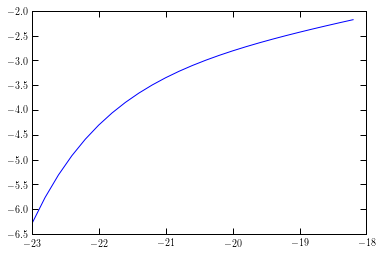

In [77]:
MUVarr=np.fromiter((x for x in np.arange(-23,-18,0.2)),np.float)
def params_bouwens(redshift):
    return {'logMstar':(-20.95 + 0.02) + (0.01) * (redshift -  6.0), \
            'phiStar': (0.47 - 0.06) * 10**(-0.27 * (redshift - 6.0)) * (10**-3.0), \
            'alpha':-1.87 + (-0.1 * (redshift - 6.0))}

bouwens_z4 = params_bouwens(4)
lumFn = schechterMUV(MUVarr,bouwens_z4)
pylab.plot(MUVarr, lumFn)

how do I sample from this distribution then?

In general, you want to have the inverse cumulative probability density function. Once you have that, then generating the random numbers along the distribution is simple:

import random

def sample(n):
    return [ icdf(random.random()) for _ in range(n) ]
Or, if you use NumPy:

import numpy as np

def sample(n):
    return icdf(np.random.random(n))
In both cases icdf is the inverse cumulative distribution function which accepts a value between 0 and 1 and outputs the corresponding value from the distribution.

To illustrate the nature of icdf, we'll take a simple uniform distribution between values 10 and 12 as an example:

probability distribution function is 0.5 between 10 and 12, zero elsewhere
cumulative distribution function is 0 below 10 (no samples below 10), 1 above 12 (no samples above 12) and increases linearly between the values (integral of the PDF)
inverse cumulative distribution function is only defined between 0 and 1. At 0 it is 10, at 12 it is 1, and changes linearly between the values
Of course, the difficult part is obtaining the inverse cumulative density function. It really depends on your distribution, sometimes you may have an analytical function, sometimes you may want to resort to interpolation. Numerical methods may be useful, as numerical integration can be used to create the CDF and interpolation can be used to invert it.

I'm actually going to follow Kevin's method - integrate luminosity function to create cumulative distribution function - should integrate between -24 and -16

In [41]:
import scipy.interpolate as interpolate
import trapZ 
def inv_cdf_LumFn(modelParams, MUV_min, MUV_max):
    #split MUV range int 10000 bins
    MUVarr = np.fromiter((x for x in np.arange(MUV_min,MUV_max,(MUV_max-MUV_min)/1000.)),np.float)
    lumFn = 10**schechterMUV(MUVarr, modelParams)
    cumFn = np.zeros(len(MUVarr))
    for i in range(1,len(MUVarr)):
        cumFn[i] = trapZ.trapZ(MUVarr[:i],lumFn[:i])
    nPerVolElement = np.max(cumFn)
    cumFn = cumFn/np.max(cumFn)
    pylab.scatter(cumFn, MUVarr)
    inv_cdf = interpolate.interp1d(cumFn, MUVarr)
    pylab.plot(cumFn, inv_cdf(cumFn))
    return inv_cdf,nPerVolElement


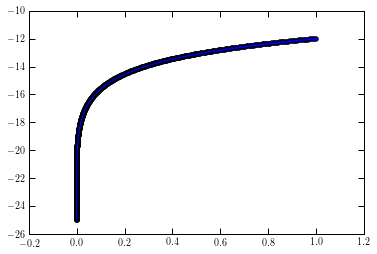

In [42]:
cumFn,nPerVolElementMUV = inv_cdf_LumFn(bouwens_z4, -25,-12)


here
-12.013312817 -21.2310941919
[    9.    39.    60.   123.   249.   440.   800.  1421.  2438.  4421.] [-21.23109419 -20.30931605 -19.38753792 -18.46575978 -17.54398164
 -16.6222035  -15.70042537 -14.77864723 -13.85686909 -12.93509095
 -12.01331282]
10 11


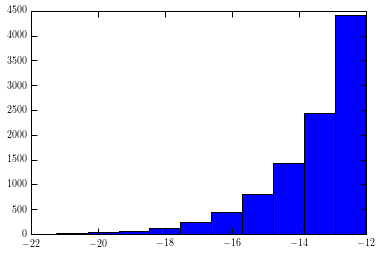

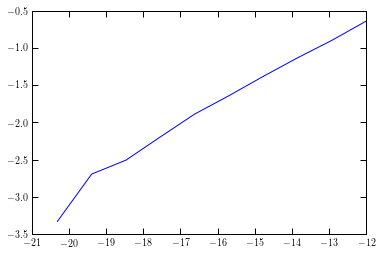

In [43]:
print 'here'
nObj = 10000
r = np.random.rand(nObj)
outputMUV = cumFn(r)
print np.max(outputMUV), np.min(outputMUV)
bins = pylab.hist(outputMUV)
print bins[0], bins[1]
figure()
print len(bins[0]), len(bins[1])
deltaBin = bins[1][1]-bins[1][0]
volMUV = nObj/nPerVolElementMUV
pylab.plot(bins[1][:-1]+deltaBin, np.log10(bins[0]/volMUV))

so I haven't been so careful about the area itself at the moment - all I want to do is match the mass function and luminosity function at z~4 and currently I'm doing that starting from the luminosity function.  I possibly should have started from the mass function... 

So, now I'll do the same for the mass function so that I can assign MUV values for given mass

In [44]:
def doubleSchechter(Marr,modelParams):
    phi = np.log(10)*np.exp((-1)*np.power(10,(Marr-modelParams['logMstar'])))*\
          np.power(10,(Marr-modelParams['logMstar'])) * \
          (10**modelParams['phiStar1']*np.power(10,((Marr-modelParams['logMstar'])*modelParams['alpha1'])) + \
           10**modelParams['phiStar2']*np.power(10,((Marr-modelParams['logMstar'])*modelParams['alpha2'])))
    return np.log10(phi)

Current parameterisation:

z<3:
 * M\* = a0 
 * logPhi\*_1 = b0 + b1\*z + b2\*z^2 
 * alpha1 = c0 + c1\*z 
 * logPhi\*_2 = d0\*(1-exp(d1\*z))+d2
 * alpha2 = e0\*(1-exp(e1\*z))+e2 
 
z>3:
 * M\* = a0 + f0*(z-3)
 * logPhi\*_1 = b0 + b1\*3 + b2\*3^2 
 * alpha1 = c0 + c1\*3 
 * logPhi\*_2 = d0\*(1-exp(d1\*3))+d2
 * alpha2 = e0\*(1-exp(e1\*3))+e2 
 
a0 10.6539859428 

b0 -3.17848941435 

b1 0.698478432181 

b2 -0.432803216317 

c0 -1.57967575579 

c1 1.14790035257 

d0 0.271397322724 

d1 -1.10050280745 

d2 -3.67920099151 

e0 0.35607484145 

e1 -1.13294712329 

e2 -1.82834644827 

f0 0.6

In [45]:
def smoothMF_old(z):
    a0 = 10.6539859428 
    b0 = -3.17848941435 
    b1 = 0.698478432181 
    b2 = -0.432803216317 
    c0 = -1.57967575579 
    c1 = 1.14790035257 
    d0 = 0.271397322724 
    d1 = -1.10050280745 
    d2 = -3.67920099151 
    e0 = 0.35607484145 
    e1 = -1.13294712329 
    e2 = -1.82834644827 
    f0 = -0.6
    
    if z<6:
        modelParams = {'logMstar':a0, \
                       'phiStar1':b0+b1*z+b2*z**2, \
                       'alpha1':c0+c1*z, \
                       'phiStar2': d0*(1-np.exp(d1*z))+d2, \
                       'alpha2': e0*(1-exp(e1*z))+e2}
    else:
        modelParams = {'logMstar':a0+f0*(z-3), \
                       'phiStar1':b0+b1*3+b2*3**2, \
                       'alpha1':c0+c1*3, \
                       'phiStar2': d0*(1-np.exp(d1*3))+d2, \
                       'alpha2': e0*(1-exp(e1*3))+e2}
    return modelParams

def smoothMF(z):
    #best Song
#     a0 = 10.6414151889 
#     b0 = -2.64116607791 
#     b1 = 0.0118199821244 
#     b2 = -0.273363832562 
#     c0 = -1.58045287113 
#     c1 = 0.927959672552 
#     d0 = -4.49458956606 
#     d1 = 0.90139011151 
#     d2 = -0.170576389609 
#     e0 = -1.97963393606 
#     e1 = 0.341011144114 
#     e2 = -0.0499793276737 
    
#best Grazian
#     a0 =10.7185065369
#     b0 =-2.89141730585
#     b1 =0.232917669973
#     b2 =-0.256725641183
#     c0 =-1.68451392999
#     c1 =0.822963347193
#     d0 =-4.94067293058
#     d1 =1.15788004624
#     d2 =-0.222202794825
#     e0 =-2.17936796677
#     e1 =0.481768633283
#     e2 =-0.0817227892681
   
#plus my MF
    a0 = 10.577528119
    b0 = -2.56854854563
    b1 = -0.367845525664
    b2 = -0.0936300278439
    c0 = -1.45567652874
    c1 = 0.968382939054
    d0 = 5.04959426496
    d1 = -4.32651910043
    d2 = -8.39105013317
    e0 = 1.16522656649
    e1 = -1.7100209345
    e2 = -2.52711422795-0.025
    
    
    modelParams = {'logMstar':a0, \
                   'phiStar1':b0+b1*z+b2*z**2, \
                   'alpha1':c0+c1*z, \
                   'phiStar2':d0*(1-np.exp(d1*z))+d2, \
                   'alpha2': e0*(1-np.exp(e1*z))+e2}
                   #'phiStar2': d0+d1*z+d2*z**2, \
                   #'alpha2': e0+e1*z+e2*z**2}
#     if z>3:
#         modelParams['logMstar'] = modelParams['logMstar']-0.35*(z-3)
    return modelParams


In [46]:
def inv_cdf_MassFn(modelParams, mass_min, mass_max):
    #split MUV range int 10000 bins
    massArr = np.fromiter((x for x in np.arange(mass_min,mass_max,(mass_max-mass_min)/1000.)),np.float)
    #should be integrated from high to low mass
    print massArr[:10]
    massArr = massArr[::-1]
    print massArr[:10]
    massFn = 10**doubleSchechter(massArr, modelParams)
    cumFn = np.zeros(len(massArr))
    for i in range(1,len(massArr)):
        cumFn[i] = trapZ.trapZ(massArr[:i],massFn[:i])
    nPerVolElement = np.max(cumFn)
    cumFn = cumFn/np.max(cumFn)
    #pylab.plot(massArr, cumFn)
    inv_cdf = interpolate.interp1d(cumFn, massArr)
    return inv_cdf,nPerVolElement

In [47]:
mf_z4 = smoothMF_old(4)
mf_z3 = smoothMF_old(3)
inv_cdf_mass,nPerVolElement = inv_cdf_MassFn(mf_z4, 6, 13)

[ 6.     6.007  6.014  6.021  6.028  6.035  6.042  6.049  6.056  6.063]
[ 12.993  12.986  12.979  12.972  12.965  12.958  12.951  12.944  12.937
  12.93 ]


In [48]:
def assignMUV(massArr, slope, intercept, scatter):
    randomArr = np.random.normal(size=len(massArr), scale=scatter)
    MUV = slope*massArr+intercept+randomArr
    return MUV

def assignMass_flat(MUVarr, slope, intercept, scatter, scatter2, pivotMagnitude):
    randomArr = np.random.normal(size=len(MUVarr), scale=scatter)
    #make scatter increase at certain point
    mass = slope*MUVarr+intercept+randomArr
    tempIdx = np.where(MUVarr <pivotMagnitude)
    mass[tempIdx[0]] = slope*pivotMagnitude+intercept+\
                        np.random.normal(size=len(tempIdx[0]), scale=scatter2)
    return mass

100 101
-1.4019525 -5.96945807


/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


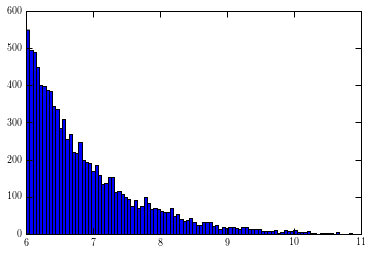

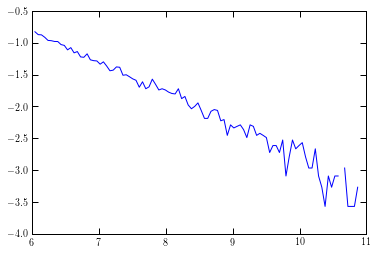

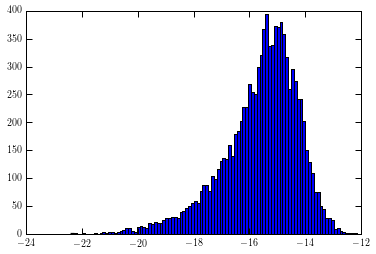

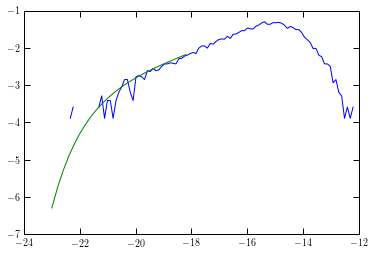

In [49]:
nObj = 10000
r = np.random.rand(nObj)
outputMass = inv_cdf_mass(r)
bins = pylab.hist(outputMass,bins=100)
figure()
print len(bins[0]), len(bins[1])
deltaBin = bins[1][1]-bins[1][0]
vol = nObj/nPerVolElement
pylab.plot(bins[1][:-1]+deltaBin, np.log10(bins[0]/vol/deltaBin))
slope = 0.00903623 * 4**3  - 1.98027122
intercept = -2.1197531  * 4 + 2.50955433
print slope, intercept
MUVval = assignMUV(outputMass, slope, intercept, 0.7)
#MUVval = assignMUV(outputMass, resultsMUV_mstar[1], resultsMUV_mstar[0], 0.7)
figure()
bins=pylab.hist(MUVval,bins=100)
figure()

deltaBin = bins[1][1]-bins[1][0]
pylab.plot(bins[1][:-1]+deltaBin/2., np.log10(bins[0]/deltaBin/vol))
pylab.plot(MUVarr, schechterMUV(MUVarr,bouwens_z4))

So, now I want to take the objects sampled from the mass function, assign MUV values and fit to the luminosity function to match the faint-end slope (and possibly phistar) of the Bouwens luminosity function

In [50]:
#I might just minimise chi2 between -21<MUV<-18.5 from a grid of intercept and slope
minChi2 = 1E10
slopeArr = np.fromiter((x for x in np.arange(-2.5,-0.5,0.01)), np.float)
interceptArr = np.fromiter((x for x in np.arange(-9,-3,0.01)),np.float)
chi2arr = np.zeros([len(slopeArr),len(interceptArr)])
for i,slope in enumerate(slopeArr):
    for j,intercept in enumerate(interceptArr):
        MUVval = assignMUV(outputMass, slope, intercept, 0.7)
        #MUVval = assignMUV(outputMass_z3, slope, intercept, 0.7)
        bins=np.histogram(MUVval,bins=100)
        deltaBin = bins[1][1]-bins[1][0]
        lumFn = schechterMUV(bins[1][:-1]+deltaBin/2.,bouwens_z4)
        #print lumFn[:10], bins[1][:10]+deltaBin
        #print lumFn-bins[0]/deltaBin/vol, np.power(lumFn-bins[0]/deltaBin/vol,2)
        if np.max(bins[1][:-1]) > -17:
            tempIdx = np.where((bins[1][:-1] > -21) & (bins[1][:-1] < -17))
            chi2 = np.sum(np.power(lumFn[tempIdx[0]]-np.log10(bins[0][tempIdx[0]]/deltaBin/vol),2))/len(tempIdx[0])
            chi2arr[i,j] = chi2
            #print chi2, slope, intercept, minChi2, min_slope, min_intercept, len(tempIdx[0])

            if chi2 < minChi2:
                min_slope = slope
                min_intercept = intercept
                minChi2=chi2        
#                 figure()
#                 pylab.plot(bins[1][:-1]+deltaBin/2,np.log10(bins[0]/deltaBin/vol))
#                 pylab.plot(bins[1][:-1]+deltaBin/2,lumFn)
#                 pylab.title(np.str(chi2)+" "+np.str(slope)+" "+np.str(intercept))
#                 pylab.ylim(-7,0)
            
print min_slope, min_intercept

/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


-1.47 -5.52


-1.47 -5.52


/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


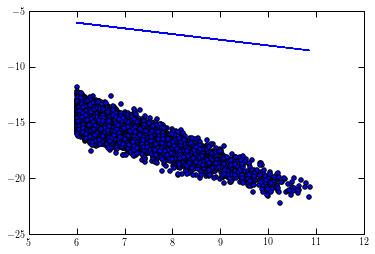

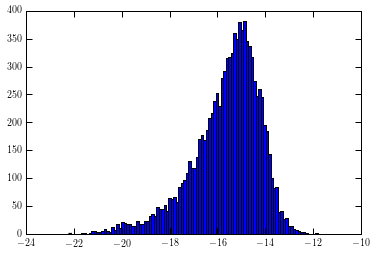

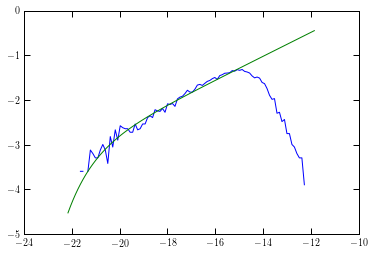

In [51]:
print min_slope, min_intercept
MUVval = assignMUV(outputMass, min_slope, min_intercept, 0.7)
figure()
pylab.scatter(outputMass, MUVval)
pylab.plot(outputMass, slope*outputMass+intercept)
figure()
bins=pylab.hist(MUVval,bins=100)
figure()

deltaBin = bins[1][1]-bins[1][0]
pylab.plot(bins[1][:-1]+deltaBin/2, np.log10(bins[0]/deltaBin/vol))
pylab.plot(bins[1][:-1]+deltaBin/2., schechterMUV(bins[1][:-1]+deltaBin/2.,bouwens_z4))


('MUV', 'mstar', 'z')
-1.47 -5.52
slope, intercept:  -1.655536222 -4.4856309
[-7.71847153 -1.27525949]


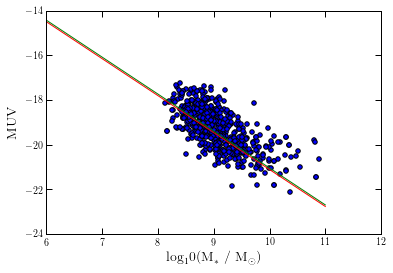

In [52]:
salp2chab = 0.243038
from astropy.io import fits
data = fits.open("../MUV_mstar_good_280717.fits")
print data[1].data.dtype.names
print min_slope, min_intercept
#pylab.plot([6,11],(min_slope)*np.array([6,11])+min_intercept)
slope = 0.00903623 * 4**3  - 1.98027122
intercept = -2.1197531  * 4 + 2.50955433

a = -0.16187211
b = -0.1937859
c = -4.4856309

z=4
intercept = a * (z-4)**2 + (b - 2*a*(z-4)) * (z-4) + c
slope = -1.655536222
print 'slope, intercept: ', slope, intercept
pylab.plot([6,11],slope*np.array([6,11])+intercept-0.07,c='r')
pylab.plot([6,11],slope*np.array([6,11])+intercept,c='g')
# pylab.plot(np.array([6,11])-salp2chab,(1./song_slope)*np.array([6,11])-\
#            song_intercept/song_slope, c='r', label='Song')
# pylab.plot(np.array([6,11]),(1./duncan_slope)*np.array([6,11])-\
#            duncan_intercept/duncan_slope, c='g', label='Duncan')
#pylab.ylim(-23,-3)
tempIdx = np.where(data[1].data['z'] > 3.5)
pylab.scatter(data[1].data['mstar'][tempIdx[0]],data[1].data['MUV'][tempIdx[0]])

import numpy.polynomial.polynomial as poly
results=poly.polyfit(data[1].data['mstar'][tempIdx[0]],data[1].data['MUV'][tempIdx[0]],1)
# pylab.plot(np.array([6,11]),\
#            poly.polyval(np.array([6,11]),results), c='b', \
#            label='simple best fit')
legend()
pylab.xlim(6,12)
print results
pylab.xlabel(r"log$_10$(M$_*$ / M$_{\odot}$)",fontsize=14)
pylab.ylabel("MUV", fontsize=14)
resultsMUV_mstar = results


In [53]:
import cosmolopy.distance as cd

def integrateLumFn(modelParams, MUV1, MUV2):
    n = 100.
    dMUV = (MUV2 - MUV1)/n
    mArr = np.fromiter((x for x in np.arange(MUV1,MUV2,dMUV)), np.float)
    phi = np.power(10,schechterMUV(mArr,modelParams))
    totalN = 0.
    for i in range(np.int(n)):
        totalN = totalN + phi[i]*dMUV
    return totalN 

def integrateVolume(N_per_Mpc3, z1, z2, dx):
    #expecting dx in arcminutes 
    area_arcsec2 = (dx*60)**2
    #1 steradian = 1 rad2 = 3282.8 deg2 = 4.25E10 arcsec2
    area_solidAngle = area_arcsec2/4.25E10
    n = 10000.
    dz = (z2-z1)/n
    zArr = np.fromiter((x for x in np.arange(z1,z2,dz)), np.float)
    
    cosmo = {'omega_M_0' : 0.3, 'omega_lambda_0' : 0.7, 'h' : 0.7}
    cosmo = cd.set_omega_k_0(cosmo)
    totalVol = 0.
    totalN = 0.
    for i in range(np.int(n)):
        dVc = cd.diff_comoving_volume(zArr[i], **cosmo)
        V = dVc * area_solidAngle * dz
        totalVol = totalVol + V
        totalN = totalN + N_per_Mpc3 * V
        
    return totalVol,totalN

def integrateVolume_model(modelParams, z1, z2, M1, M2, dx):
    #expecting dx in arcminutes 
    area_arcsec2 = (dx*60)**2
    #1 steradian = 1 rad2 = 3282.8 deg2 = 4.25E10 arcsec2
    area_solidAngle = area_arcsec2/4.25E10
    n = 10000.
    dz = (z2-z1)/n
    zArr = np.fromiter((x for x in np.arange(z1,z2,dz)), np.float)
    
    cosmo = {'omega_M_0' : 0.3, 'omega_lambda_0' : 0.7, 'h' : 0.72}
    cosmo = cd.set_omega_k_0(cosmo)
    totalVol = 0.
    totalN = 0.
    for i in range(np.int(n)):
        dVc = cd.diff_comoving_volume(zArr[i], **cosmo)
        massFn_SF = {'logMstar':modelParams['a0'], \
         'phiStar1':modelParams['b0'] + modelParams['b1']*zArr[i] + modelParams['b2']*zArr[i]**2, \
         'alpha1':modelParams['c0'] + modelParams['c1']*zArr[i], \
         'phiStar2':modelParams['d0'] + modelParams['d1']*zArr[i] + modelParams['d2']*zArr[i]**2 , \
         'alpha2':modelParams['e0'] + modelParams['e1']*zArr[i] + modelParams['e2']*zArr[i]**2}
        N_per_Mpc3 = integrateLumFn(massFn_SF, M1, M2)
        V = dVc * area_solidAngle * dz
        totalVol = totalVol + V
        totalN = totalN + N_per_Mpc3 * V
        
    return totalVol,totalN
    

In [54]:
#starting in a bin 3.9<z<4.0 
print resultsMUV_mstar
#MUVval = assignMUV(outputMass, min_slope, min_intercept, 0.7)
MUVval = assignMUV(outputMass, resultsMUV_mstar[1], resultsMUV_mstar[0], 0.7)
tempIdx = np.where(MUVval < -16)
N = len(tempIdx[0])
N_per_Mpc3 = N/vol

slope = 0.00903623 * 4**3  - 1.98027122
intercept = -2.1197531  * 4 + 2.50955433
MUVval_orig = assignMUV(outputMass, slope, intercept, 0.7)
tempIdx = np.where(MUVval_orig < -16)
N = len(tempIdx[0])
N_per_Mpc3_orig = N/vol

totalVol, totalN = integrateVolume(N_per_Mpc3, 3.9, 4.0, 11)
print N_per_Mpc3, totalN, totalVol

bouwens_N_per_Mpc3 = integrateLumFn(bouwens_z4, -24, -16)
print bouwens_N_per_Mpc3, np.log10(bouwens_N_per_Mpc3*totalVol), bouwens_N_per_Mpc3*totalVol
print N_per_Mpc3_orig, np.log10(N_per_Mpc3_orig*totalVol), N_per_Mpc3_orig*totalVol
print N_per_Mpc3, np.log10(N_per_Mpc3*totalVol), N_per_Mpc3*totalVol


[-7.71847153 -1.27525949]
0.079746337822 2926.63490564 36699.3016304
0.0391312060834 3.15718103365 1436.08793522
0.0420042983612 3.18795153458 1541.52841533
0.079746337822 3.46636854807 2926.63490564


[ 2.397856   -0.34618455]
intercept:  -1.64
-4.4856309
0.366208
[ 5.13749426  7.99803139  7.51559117  7.19607537  6.73736752  5.53083489
  5.73782316  5.17710663  6.64347391  6.95967179]
[ 6.     6.007  6.014  6.021  6.028  6.035  6.042  6.049  6.056  6.063]
[ 12.993  12.986  12.979  12.972  12.965  12.958  12.951  12.944  12.937
  12.93 ]


/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log10
/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log10


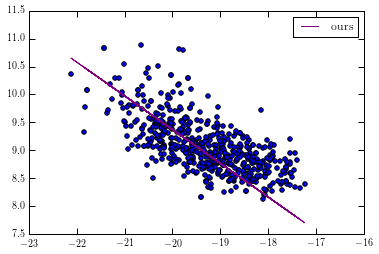

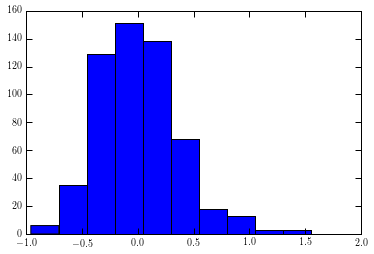

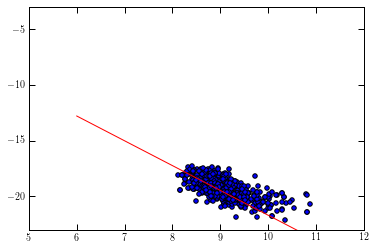

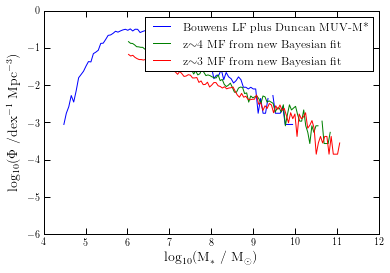

In [55]:
#what would the mass function look like with the Bouwens LF and the measured M*-MUV?
salp2chab = 0.243038

figure()
tempIdx = np.where(data[1].data['z'] > 3.5)
pylab.scatter(data[1].data['MUV'][tempIdx[0]],data[1].data['mstar'][tempIdx[0]])

import numpy.polynomial.polynomial as poly
#fitting to M* vs MUV
results=poly.polyfit(data[1].data['MUV'][tempIdx[0]],data[1].data['mstar'][tempIdx[0]],1)
# pylab.plot(data[1].data['MUV'][tempIdx[0]],poly.polyval(data[1].data['MUV'][tempIdx[0]],results),\
#            label="best fit")
print results
delta = data[1].data['mstar'][tempIdx[0]]-poly.polyval(data[1].data['MUV'][tempIdx[0]],results)

#plot Song M*-MUV
song_slope = -0.54
song_intercept = 9.7 - song_slope*(-21)
print 'intercept: ', song_intercept
# pylab.plot(data[1].data['MUV'][tempIdx[0]],poly.polyval(data[1].data['MUV'][tempIdx[0]],\
#                                [song_intercept, song_slope])-salp2chab,c='r', label='Song')

duncan_slope = -0.45
duncan_intercept = 9.02 - duncan_slope*(-19.5)
# pylab.plot(data[1].data['MUV'][tempIdx[0]],poly.polyval(data[1].data['MUV'][tempIdx[0]],\
#                                [duncan_intercept, duncan_slope]),c='g', label='Duncan')

a = -0.16187211
b = -0.1937859
c = -4.4856309

z=4
current_M_MUV_intercept_z4 = a * (z-4)**2 + (b - 2*a*(z-4)) * (z-4) + c
print current_M_MUV_intercept_z4
current_M_MUV_slope_z4 = -1.655536222
current_M_MUV_intercept_z4 = current_M_MUV_intercept_z4
# pylab.plot(data[1].data['MUV'][tempIdx[0]],poly.polyval(data[1].data['MUV'][tempIdx[0]],\
#                                [(-1)*intercept/slope, 1./slope]),c='purple', label='ours')
pylab.plot(data[1].data['MUV'][tempIdx[0]],poly.polyval(data[1].data['MUV'][tempIdx[0]],\
                                [(-1)*current_M_MUV_intercept_z4/current_M_MUV_slope_z4, \
                                 1./current_M_MUV_slope_z4]),c='purple', label='ours')

legend()

figure()
pylab.hist(delta)
print np.std(delta)

figure()
pylab.plot([6,11],1./duncan_slope*np.array([6,11])+(-1)*duncan_intercept/duncan_slope,c='r',\
          label='duncan+15 M*-MUV')
pylab.ylim(-23,-3)
tempIdx = np.where(data[1].data['z'] > 3.5)
pylab.scatter(data[1].data['mstar'][tempIdx[0]],data[1].data['MUV'][tempIdx[0]])

mass_bouwens_lf = assignMUV(outputMUV, 1/resultsMUV_mstar[1], \
                            (-1)*resultsMUV_mstar[0]/resultsMUV_mstar[1], 0.4)
#mass_bouwens_lf = assignMUV(outputMUV, results[1], results[0], 0.366)
#mass_bouwens_lf = assignMUV(outputMUV, song_slope, song_intercept, 0.4)
mass_bouwens_lf = assignMUV(outputMUV, duncan_slope, duncan_intercept, 0.4)
print mass_bouwens_lf[:10]
figure()
# bins=np.histogram(mass_bouwens_lf-salp2chab,bins=100)
# deltaBin = bins[1][1]-bins[1][0]
# pylab.plot(bins[1][:-1]+deltaBin/2., np.log10(bins[0]/deltaBin/volMUV), \
#            label='Bouwens LF plus Song M*-MUV')
bins=np.histogram(mass_bouwens_lf,bins=100)
deltaBin = bins[1][1]-bins[1][0]
pylab.plot(bins[1][:-1]+deltaBin/2., np.log10(bins[0]/deltaBin/volMUV), \
              label='Bouwens LF plus Duncan MUV-M*')

bins = np.histogram(outputMass,bins=100)
deltaBin = bins[1][1]-bins[1][0]
pylab.plot(bins[1][:-1]+deltaBin/2., np.log10(bins[0]/vol/deltaBin), \
           label=r"z$\sim$4 MF from new Bayesian fit")

#plot z~3 mass fn
mf_z3 = smoothMF(3)
inv_cdf_mass_z3,nPerVolElementZ3 = inv_cdf_MassFn(mf_z3, 6, 13)
outputMass_z3 = inv_cdf_mass_z3(r)
vol_z3 = len(r)/nPerVolElementZ3

bins = np.histogram(outputMass_z3,bins=100)
deltaBin = bins[1][1]-bins[1][0]
pylab.plot(bins[1][:-1]+deltaBin/2., np.log10(bins[0]/vol_z3/deltaBin), c='r', \
           label=r'z$\sim$3 MF from new Bayesian fit')
pylab.xlabel(r"log$_{10}$(M$_*$ / M$_{\odot}$)",fontsize=14)
pylab.ylabel(r"log$_{10}(\Phi$ /dex$^{-1}$ Mpc$^{-3}$)",fontsize=14)

#pylab.plot(bins[1][:-1]+deltaBin/2., schechter(bins[1][:-1]+deltaBin/2.,duncan_z4_mass),c='r')
pylab.ylim(-6,0)
legend()

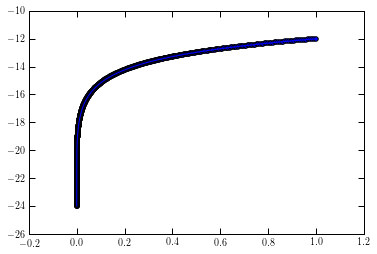

In [56]:
#Duncan LF->MF
duncan_z4 = {'phiStar':1.9E-3, 'logMstar':-20.47, 'alpha':-1.77}
duncan_mf_z4 = {'phiStar':1.89E-4, 'logMstar':10.51, 'alpha':-1.89}
cumFnDun,nPerVolElementMUV_dun = inv_cdf_LumFn(duncan_z4, -24,-12)


51174.0934677 0.977056878039


/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


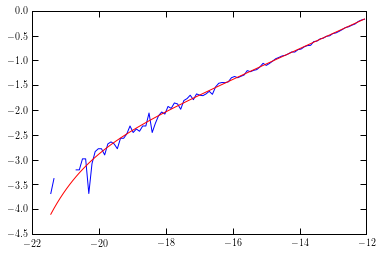

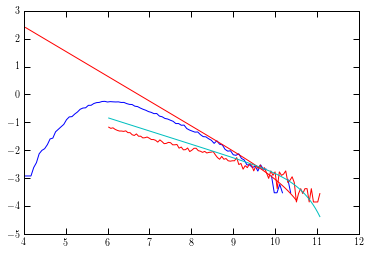

In [57]:
r = np.random.rand(50000)
volMUV_dun = len(r)/nPerVolElementMUV_dun
print volMUV_dun, nPerVolElementMUV_dun
outputMUV_dun = cumFnDun(r)

figure()
bins=np.histogram(outputMUV_dun,bins=100)
deltaBin = bins[1][1]-bins[1][0]
pylab.plot(bins[1][:-1]+deltaBin/2., np.log10(bins[0]/deltaBin/volMUV_dun))
pylab.plot(bins[1][:-1]+deltaBin/2., schechterMUV(bins[1][:-1]+deltaBin/2.,duncan_z4),c='r')

mass_duncan_lf = assignMUV(outputMUV_dun, duncan_slope, duncan_intercept, 0.5)

#estimate mass function scaling
#tempIdx =
figure()
bins=np.histogram(mass_duncan_lf,bins=100)
deltaBin = bins[1][1]-bins[1][0]
pylab.plot(bins[1][:-1]+deltaBin/2., np.log10(bins[0]/deltaBin/volMUV_dun))
pylab.plot(bins[1][:-1]+deltaBin/2., schechter(bins[1][:-1]+deltaBin/2.,duncan_mf_z4),c='r')

bins = np.histogram(outputMass_z3,bins=100)
deltaBin = bins[1][1]-bins[1][0]
pylab.plot(bins[1][:-1]+deltaBin/2., np.log10(bins[0]/vol_z3/deltaBin), c='r')
pylab.plot(bins[1][:-1]+deltaBin/2., doubleSchechter(bins[1][:-1]+deltaBin/2.,mf_z4))

In [58]:

import matplotlib.pyplot as plt
import scipy.integrate as itg
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
import astropy.units as u
import sys
import math
from astropy.io import fits
from astropy.io import ascii
from scipy import interpolate
from scipy.integrate import quad

# Try Song 2016 mass, converted to Chabrier IMF:
def songmass(redshift, magnitude, scatter):

    # We don't want to extrapolate to higher redshifts, but would rather just
    # keep the mass relationship set to what it is at z = 8
    if (redshift > 8.0): 
        redshift = 8.0

    # What is the age of the universe at this redshift: 
    age_value = cosmo.age(redshift).value * 3.1536e+16

    # These values are from Song et al. 2016
    dmassz = [4.0, 5.0, 6.0, 7.0]
    dmassslope = [-0.54,-.5,-.5,-.65]
    dmassslope_err = [.03,.04, .03,.1]

    dmassintercept = [9.7,9.59,9.53,9.36]
    dmassintercept_err = [.02,.03,.02,.16]

    # we have to convert the redshifts into age of the universe at this redshift,
    # since we'll want to interpolate in terms of age, and not redshift. 
    dmassage = np.zeros(len(dmassz))
    for w in range(0,len(dmassz)):
        dmassage[w] = cosmo.age(dmassz[w]).value * 3.1536e+16

    # Interpolate the intercept and the slope of M*-Muv dist
    dmassintercept_interp = interpolate.InterpolatedUnivariateSpline(dmassage, dmassintercept, k = 3)
    dmassintercept_err_interp = interpolate.InterpolatedUnivariateSpline(dmassage, dmassintercept_err, k = 3)
    dmassslope_interp = interpolate.InterpolatedUnivariateSpline(dmassage, dmassslope, k = 3)
    dmassslope_err_interp = interpolate.InterpolatedUnivariateSpline(dmassage, dmassslope_err, k = 3)

    dmassintercept_value = dmassintercept_interp(age_value)
    dmassslope_value = dmassslope_interp(age_value)

    dmassyintercept_value = (dmassintercept_value - (-21)*(dmassslope_value))
    
    lgmass = dmassslope_value * (magnitude) + dmassyintercept_value

    # add scatter to the distribution:
    lgmass = lgmass + np.random.normal(loc=0,scale=scatter,size=len(magnitude))

    return lgmass, dmassslope_value, dmassyintercept_value


cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)


-0.54 -1.64
-0.54 -1.64


/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


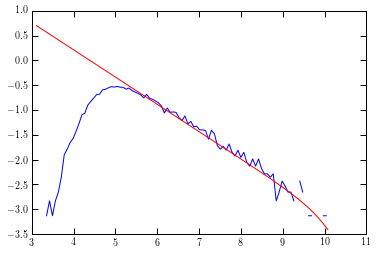

In [59]:
bouwens_song_mass_christina,song_slope_z4, song_intercept_z4 = songmass(4, outputMUV, 0.4)
print song_slope, song_intercept
print song_slope_z4, song_intercept_z4
salp2chab = 0.243038
bouwens_song_mass_christina = bouwens_song_mass_christina - salp2chab

figure()
bins=np.histogram(bouwens_song_mass_christina,bins=100)
deltaBin = bins[1][1]-bins[1][0]
pylab.plot(bins[1][:-1]+deltaBin/2., np.log10(bins[0]/deltaBin/volMUV))
pylab.plot(bins[1][:-1]+deltaBin/2.-salp2chab, schechter(bins[1][:-1]+deltaBin/2.,song_z4_mass),c='r')

-4.4856309


/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


[ -0.83579877  -0.88120834  -0.92662039  -0.97203556  -1.01745465
  -1.06287869  -1.10830896  -1.15374706  -1.19919503  -1.24465542
  -1.29013145  -1.33562716  -1.38114765  -1.42669934  -1.47229031
  -1.51793072  -1.56363338  -1.60941441  -1.6552941   -1.70129799
  -1.74745825  -1.79381535  -1.84042027  -1.88733718  -1.93464685
  -1.98245099  -2.03087762  -2.08008791  -2.1302848   -2.18172371
  -2.23472626  -2.28969729  -2.34714652  -2.40771559  -2.47221232
  -2.54165367  -2.61731995  -2.70082293  -2.79419175  -2.89998091
  -3.02140636  -3.16251672  -3.32840894  -3.52549965  -3.76186694
  -4.04768052  -4.39574327  -4.82217311  -5.34726126  -5.99655286
  -6.80220734  -7.80471102  -9.05503316 -10.61734027 -12.57241318
 -15.02194893 -18.09397653 -21.94967491 -26.79195638 -32.87627235]
5.875 6.0 0.117419047668 0.000583811257147
6.125 6.25 0.0908706569673 0.000372565467195
6.375 6.5 0.070383552132 0.00041974344774
6.625 6.75 0.0545298440367 0.000276247212626
6.875 7.0 0.0418495677863 0.0001

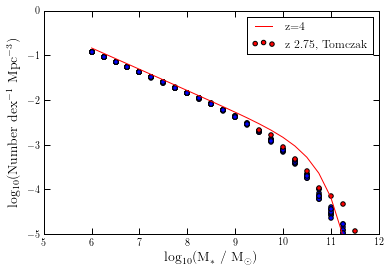

In [60]:
#so I'm going to make measurements for the bouwens z~4 LF transformed into a mass function 
#using our measured M*-MUV relation

deltaBin=0.25
binsIn = np.fromiter((x for x in np.arange(6,12,deltaBin)),np.float)-deltaBin/2.
nIter = 10 #100
plotMF = True

a = -0.16187211
b = -0.1937859
c = -4.4856309

z=4
current_M_MUV_intercept_z4 = a * (z-4)**2 + (b - 2*a*(z-4)) * (z-4) + c
print current_M_MUV_intercept_z4
slope = -1.655536222 
current_M_MUV_intercept_z4 = current_M_MUV_intercept_z4 - 0.2
    
# slope_z3 = 0.00903623 * 3**3  - 1.98027122
# intercept_z3 = -2.1197531  * 3 + 2.50955433
slope_z3 = slope
intercept_z3 = current_M_MUV_intercept_z4
outputMF = np.zeros([len(binsIn)-1,nIter])

for j in range(nIter):
    nObj = 1000000
    r = np.random.rand(nObj)
    outputMUV = cumFn(r)
    volMUV = nObj/nPerVolElementMUV


    mass_bouwens_lf_flat = assignMUV(outputMUV, 1/slope_z3, \
                                 (-1)*intercept_z3/slope_z3, 0.426)
#    mass_bouwens_lf_flat = assignMUV(outputMUV, 1/resultsMUV_mstar[1], \
#                                 (-1)*resultsMUV_mstar[0]/resultsMUV_mstar[1], 0.4)
    
#     mass_bouwens_lf_flat = assignMass_flat(outputMUV, 1/resultsMUV_mstar[1], \
#                                          (-1)*resultsMUV_mstar[0]/resultsMUV_mstar[1], \
#                                            0.4,0.4,-20.3)


    bins = np.histogram(mass_bouwens_lf_flat,bins=binsIn)
    outputMF[:,j] = bins[0]/deltaBin/volMUV
    if plotMF:
        pylab.scatter(bins[1][:-1]+deltaBin/2., np.log10(bins[0]/volMUV/deltaBin))
    else:
        pylab.scatter(mass_bouwens_lf_flat, outputMUV)
    

if not plotMF:
    pylab.scatter(data[1].data['mstar'][tempIdx[0]],data[1].data['MUV'][tempIdx[0]], c='r')
else:
    pylab.plot(bins[1][:-1]+deltaBin/2., doubleSchechter(bins[1][:-1]+deltaBin/2., mf_z4),\
               c='r', label="z=4")
#     pylab.plot(bins[1][:-1]+deltaBin/2., doubleSchechter(bins[1][:-1]+deltaBin/2., mf_z3),\
#                c='g', label="z=3")
    
tempMarr = np.fromiter((x for x in np.arange(6,12,0.1)),np.float)

# pylab.plot(tempMarr, schechter(tempMarr,{'phiStar':0.0009,'logMstar':10.07, 'alpha':-1.454}),\
#            c='k', label="Christina's fit")
mass = [9.5,9.75,10,10.25,10.5,10.75,11,11.25,11.5]
MF = [-2.66,-2.79,-3.06,-3.32,-3.59,-3.97,-4.16,-4.32,-4.94]
pylab.scatter(mass,MF, c='r', s=20, label="z~2.75, Tomczak")
print schechter(tempMarr,{'phiStar':0.0009,'logMstar':10.07, 'alpha':-1.454})
pylab.xlabel(r"log$_{10}$(M$_*$ / M$_{\odot}$)", fontsize=14)
pylab.ylabel(r"log$_{10}$(Number dex$^{-1}$ Mpc$^{-3}$)", fontsize=14)
pylab.ylim(-5,0)
legend()
avgMF = []
avgMF_err = []
for i in range(len(bins[0])):
    print bins[1][i], bins[1][i]+deltaBin/2., np.median(outputMF[i,:]), np.std(outputMF[i,:])
    avgMF.append(np.median(outputMF[i,:]))
    avgMF_err.append(np.std(outputMF[i,:]))
    
# pylab.scatter([4.25,4.75,5.25,5.75,6.25,6.75,7.25,7.75,8.25,8.75,9.25,9.75,10.25,10.75,11.25,11.75],\
#               [-2.275755,-1.305287,-0.843653,-0.775433,-0.936811,-1.155209,\
#                -1.368826,-1.598108,-1.850165,-2.099664,-2.379063,-2.760812,\
#                -3.187397,-3.684722,-4.353728,-5.131880],c='g')
#                -2.275755 0.016197
# 4.750000 -1.305287 0.005299
# 5.250000 -0.843653 0.003114
# 5.750000 -0.775433 0.002879
# 6.250000 -0.936811 0.003467
# 6.750000 -1.155209 0.004458
# 7.250000 -1.368826 0.005701
# 7.750000 -1.598108 0.007423
# 8.250000 -1.850165 0.009923
# 8.750000 -2.099664 0.013225
# 9.250000 -2.379063 0.018242
# 9.750000 -2.760812 0.028311
# 10.250000 -3.187397 0.046265
# 10.750000 -3.684722 0.082018
# 11.250000 -4.353728 0.177180
# 11.750000 -5.131880 0.434000

In [61]:
bins = np.fromiter((x for x in np.arange(8,12,0.25)),np.float)-0.25/2.
print bins

[  7.875   8.125   8.375   8.625   8.875   9.125   9.375   9.625   9.875
  10.125  10.375  10.625  10.875  11.125  11.375  11.625]


In [62]:
resultsMUV_mstar

array([-7.71847153, -1.27525949], dtype=float32)

In [63]:
testArr = [0.1,0.09,0.3,0.3,0.3]
bins = np.histogram(testArr,bins=[0,0.1,0.2,0.3,0.4,0.5])
print bins

(array([1, 1, 0, 3, 0]), array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5]))


In [64]:

from scipy.optimize.minpack import curve_fit
def dbl_schecter_fit(x, alpha_two,  phistar_two, logM_star):
    #phistar_one = 10**(logphistar_one)
    #phistar_two = 10**(logphistar_two)
        
    alpha_one = 3.67889474274#3.011
    phistar_one = 10.**(-7.5827303564)#-7.3094)

    term_one = (np.log(10.0))
    term_two = (np.exp(-10.0**(x - logM_star)))
    term_three = (10.0**(x - logM_star))
    term_four = ((phistar_one * (10.0**((x - logM_star)*alpha_one))) + (phistar_two * (10.0**((x - logM_star)*alpha_two))))
    phiM = term_one * term_two * term_three * term_four
    
    return phiM;

print len(avgMF)
print len(avgMF_err)
int_exp, pcov = curve_fit(dbl_schecter_fit, binsIn[:-1]+deltaBin/2., avgMF, sigma=avgMF_err, p0=[-1.67,10**(-3.71),10.61])

23
23


In [65]:
print int_exp

[ -1.46251560e+00   6.41984235e-04   1.01271316e+01]


In [66]:
print np.log10(int_exp)


[        nan -3.19247564  1.00548645]


/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(-3, 0)

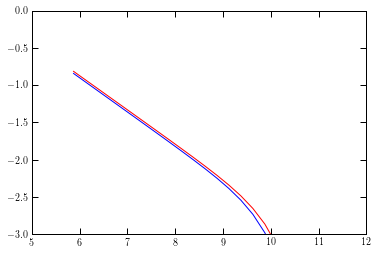

In [67]:
modelParams1 = {'logMstar':1.00307032e+01, \
                   'phiStar1':-7.5827303564, \
                   'alpha1':3.67889474274, \
                   'phiStar2': -3.1145276, \
                   'alpha2': -1.45951902}
pylab.plot(binsIn, doubleSchechter(binsIn, modelParams1))
modelParams2 = {'logMstar':10.17480199, \
                   'phiStar1':-7.5827303564, \
                   'alpha1':3.67889474274, \
                   'phiStar2': -3.14937214156, \
                   'alpha2': -1.45880041}
pylab.plot(binsIn, doubleSchechter(binsIn, modelParams2),c='r')

pylab.ylim(-3,0)

In [68]:
print intercept, slope


-5.96945807 -1.655536222


In [69]:
mass = np.random.uniform(size=100000)*10+6
MUV = assignMUV(mass, slope, intercept, 0.7)


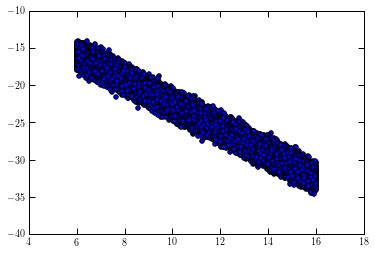

In [70]:
pylab.scatter(mass, MUV)


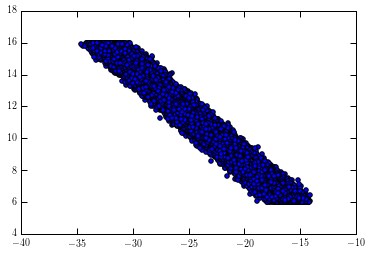

In [71]:
pylab.scatter(MUV,mass)



[-1.79679711 -1.67971859 -1.56264007 -1.44556155 -1.32848303 -1.21140451
 -1.09432599 -0.97724747 -0.86016895 -0.74309043 -0.62601191 -0.50893339
 -0.39185487 -0.27477636 -0.15769784 -0.04061932  0.0764592   0.19353772
  0.31061624  0.42769476  0.54477328  0.6618518   0.77893032  0.89600884
  1.01308736  1.13016588  1.2472444   1.36432292  1.48140144  1.59847996
  1.71555848]
31 30


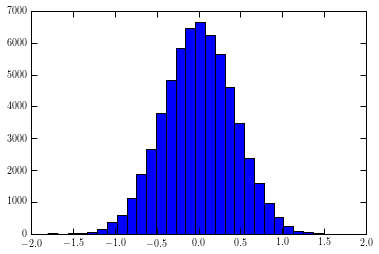

In [72]:
tempIdx = np.where((MUV > -30) & (MUV < -20))
delta = mass[tempIdx] - (1/slope*MUV[tempIdx]-intercept/slope)
bins = pylab.hist(delta,bins=30)
print bins[1]
binDelta = bins[1][1]-bins[1][0]
print len(bins[1]), len(bins[0])


In [73]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt, pcov = curve_fit(gauss_function, bins[1][:-1]+binDelta/2., bins[0], p0 = [1, 0, 0.4])


[  6.64396353e+03   1.83557567e-03   4.24411050e-01]


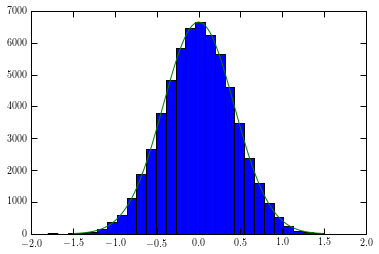

In [74]:
print popt
pylab.hist(delta,bins=30)
pylab.plot(np.arange(-1.5,1.5,0.01), gauss_function(np.arange(-1.5,1.5,0.01),popt[0],popt[1],popt[2]))
